# Day 1: Return & Momentum Features

## Learning Objectives
- Build return-based features at multiple horizons
- Create momentum and acceleration indicators
- Understand feature standardization for ML

---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

print("✅ Libraries loaded!")
print("📚 Day 1: Return & Momentum Features")

✅ Libraries loaded!
📚 Day 1: Return & Momentum Features


In [2]:
# ============================================================
# GENERATE PRICE DATA
# ============================================================

print("GENERATING PRICE DATA")
print("="*60)

np.random.seed(42)
n_days = 1000

# Simulate realistic returns
returns = np.random.normal(0.0003, 0.015, n_days)
for i in range(1, len(returns)):
    returns[i] += 0.05 * returns[i-1]  # Slight momentum

prices = 100 * np.cumprod(1 + returns)

df = pd.DataFrame({
    'price': prices,
    'returns': returns
})

print(f"Data: {len(df)} days")
print(f"Price range: ${df['price'].min():.2f} - ${df['price'].max():.2f}")

GENERATING PRICE DATA
Data: 1000 days
Price range: $82.70 - $189.03


## Part 1: Multi-Horizon Returns

RETURN FEATURES
Created features:
  • returns
  • ret_1d
  • ret_2d
  • ret_3d
  • ret_5d
  • ret_10d
  • ret_20d
  • ret_60d
  • log_ret_5d
  • log_ret_20d


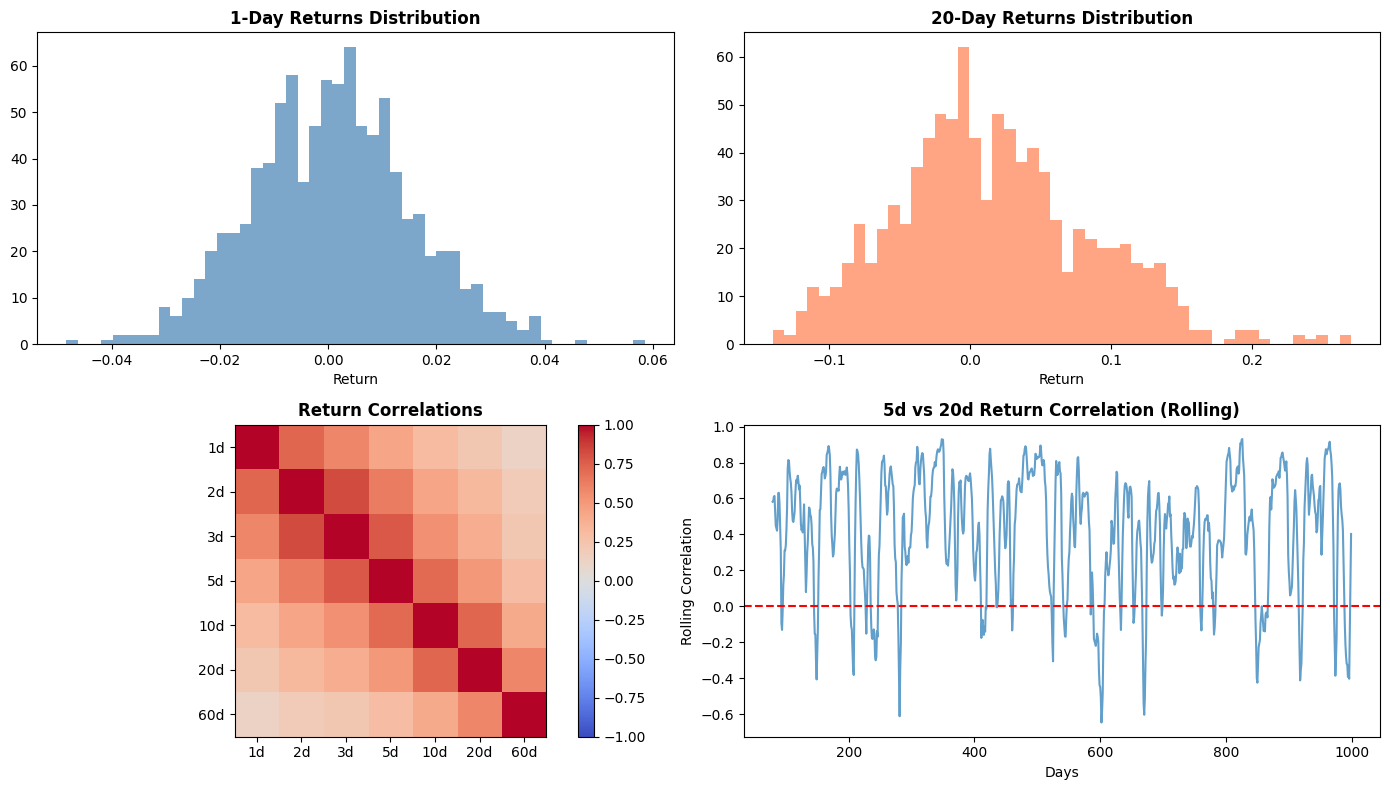

In [3]:
# ============================================================
# RETURN FEATURES
# ============================================================

print("RETURN FEATURES")
print("="*60)

# Different horizons capture different dynamics
horizons = [1, 2, 3, 5, 10, 20, 60]

for h in horizons:
    df[f'ret_{h}d'] = df['price'].pct_change(h)

# Log returns (better for longer horizons)
for h in [5, 20]:
    df[f'log_ret_{h}d'] = np.log(df['price'] / df['price'].shift(h))

print("Created features:")
for col in df.columns:
    if 'ret' in col:
        print(f"  • {col}")

# Visualize
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

df_clean = df.dropna()

axes[0, 0].hist(df_clean['ret_1d'], bins=50, alpha=0.7, color='steelblue')
axes[0, 0].set_xlabel('Return')
axes[0, 0].set_title('1-Day Returns Distribution', fontweight='bold')

axes[0, 1].hist(df_clean['ret_20d'], bins=50, alpha=0.7, color='coral')
axes[0, 1].set_xlabel('Return')
axes[0, 1].set_title('20-Day Returns Distribution', fontweight='bold')

corrs = df_clean[[f'ret_{h}d' for h in horizons]].corr()
im = axes[1, 0].imshow(corrs, cmap='coolwarm', vmin=-1, vmax=1)
axes[1, 0].set_xticks(range(len(horizons)))
axes[1, 0].set_yticks(range(len(horizons)))
axes[1, 0].set_xticklabels([f'{h}d' for h in horizons])
axes[1, 0].set_yticklabels([f'{h}d' for h in horizons])
axes[1, 0].set_title('Return Correlations', fontweight='bold')
plt.colorbar(im, ax=axes[1, 0])

axes[1, 1].plot(df_clean['ret_5d'].rolling(20).corr(df_clean['ret_20d']), alpha=0.7)
axes[1, 1].set_xlabel('Days')
axes[1, 1].set_ylabel('Rolling Correlation')
axes[1, 1].set_title('5d vs 20d Return Correlation (Rolling)', fontweight='bold')
axes[1, 1].axhline(0, color='red', linestyle='--')

plt.tight_layout()
plt.show()

## Part 2: Momentum Features

In [4]:
# ============================================================
# MOMENTUM FEATURES
# ============================================================

print("MOMENTUM FEATURES")
print("="*60)

# Rolling sum of returns (classic momentum)
for period in [5, 10, 20]:
    df[f'mom_{period}d'] = df['returns'].rolling(period).sum()

# Rolling mean (normalized momentum)
for period in [5, 10, 20]:
    df[f'avg_ret_{period}d'] = df['returns'].rolling(period).mean()

# Momentum acceleration (change in momentum)
df['mom_accel_5d'] = df['mom_5d'] - df['mom_5d'].shift(5)
df['mom_accel_10d'] = df['mom_10d'] - df['mom_10d'].shift(10)

# Up/Down ratio
def up_down_ratio(rets, window):
    up = (rets > 0).rolling(window).sum()
    down = (rets < 0).rolling(window).sum()
    return up / (down + 1)  # Add 1 to avoid division by zero

df['up_down_ratio_10d'] = up_down_ratio(df['returns'], 10)
df['up_down_ratio_20d'] = up_down_ratio(df['returns'], 20)

print("Created momentum features:")
for col in df.columns:
    if 'mom' in col or 'avg_ret' in col or 'up_down' in col:
        print(f"  • {col}")

MOMENTUM FEATURES
Created momentum features:
  • mom_5d
  • mom_10d
  • mom_20d
  • avg_ret_5d
  • avg_ret_10d
  • avg_ret_20d
  • mom_accel_5d
  • mom_accel_10d
  • up_down_ratio_10d
  • up_down_ratio_20d


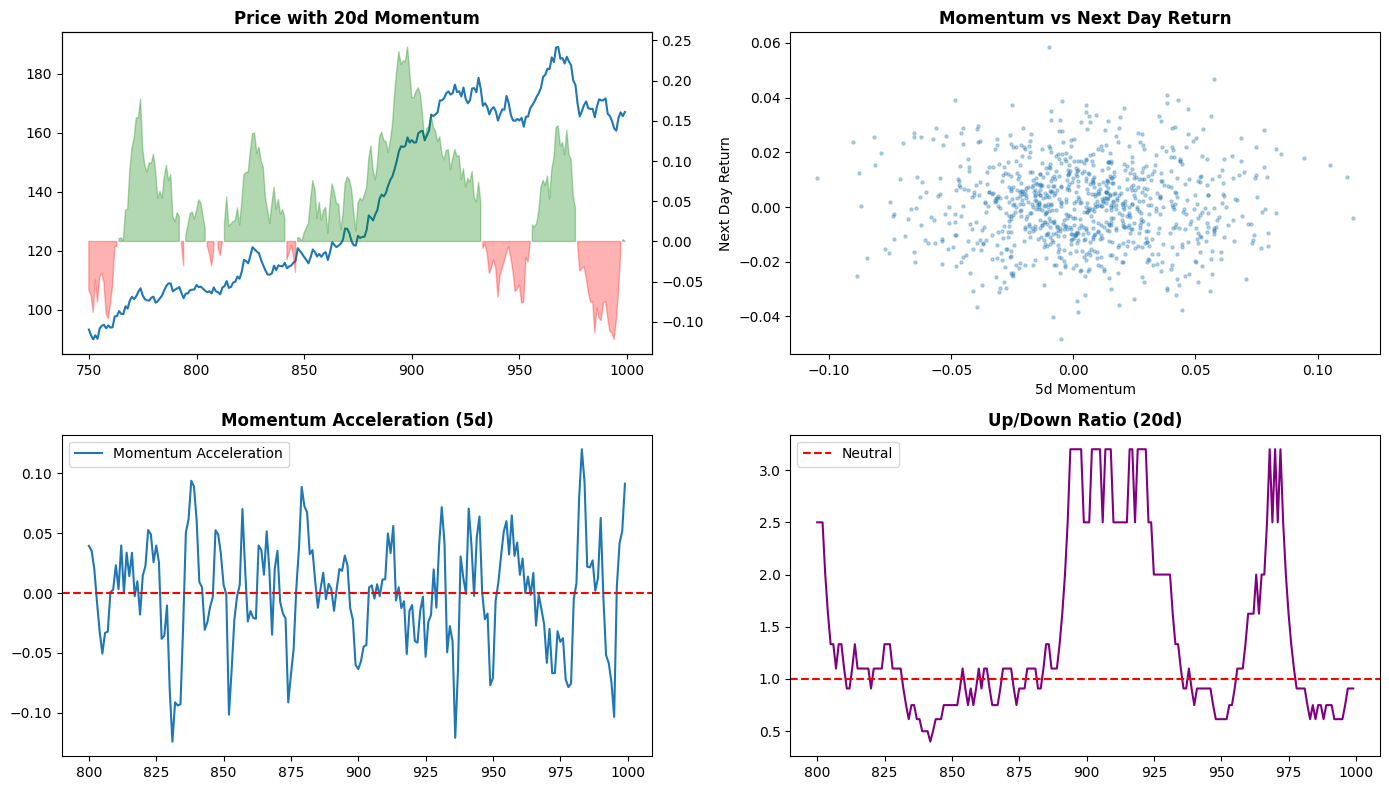

In [5]:
# ============================================================
# VISUALIZE MOMENTUM
# ============================================================

df_clean = df.dropna()

fig, axes = plt.subplots(2, 2, figsize=(14, 8))

axes[0, 0].plot(df_clean.index[-250:], df_clean['price'].iloc[-250:], label='Price')
ax2 = axes[0, 0].twinx()
ax2.fill_between(df_clean.index[-250:], df_clean['mom_20d'].iloc[-250:], 0, alpha=0.3, color='green',
                 where=df_clean['mom_20d'].iloc[-250:] > 0)
ax2.fill_between(df_clean.index[-250:], df_clean['mom_20d'].iloc[-250:], 0, alpha=0.3, color='red',
                 where=df_clean['mom_20d'].iloc[-250:] < 0)
axes[0, 0].set_title('Price with 20d Momentum', fontweight='bold')

axes[0, 1].scatter(df_clean['mom_5d'], df_clean['returns'].shift(-1), alpha=0.3, s=5)
axes[0, 1].set_xlabel('5d Momentum')
axes[0, 1].set_ylabel('Next Day Return')
axes[0, 1].set_title('Momentum vs Next Day Return', fontweight='bold')

axes[1, 0].plot(df_clean['mom_accel_5d'].iloc[-200:], label='Momentum Acceleration')
axes[1, 0].axhline(0, color='red', linestyle='--')
axes[1, 0].set_title('Momentum Acceleration (5d)', fontweight='bold')
axes[1, 0].legend()

axes[1, 1].plot(df_clean['up_down_ratio_20d'].iloc[-200:], color='purple')
axes[1, 1].axhline(1, color='red', linestyle='--', label='Neutral')
axes[1, 1].set_title('Up/Down Ratio (20d)', fontweight='bold')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

## Part 3: Feature Standardization

In [6]:
# ============================================================
# STANDARDIZATION
# ============================================================

print("FEATURE STANDARDIZATION")
print("="*60)

feature_cols = [c for c in df.columns if c not in ['price', 'returns']]
df_features = df[feature_cols].dropna()

# Z-score standardization (for ML)
scaler = StandardScaler()
df_scaled = pd.DataFrame(
    scaler.fit_transform(df_features),
    columns=feature_cols,
    index=df_features.index
)

print("\nBefore standardization:")
print(df_features.describe().T[['mean', 'std', 'min', 'max']].head())

print("\nAfter standardization:")
print(df_scaled.describe().T[['mean', 'std', 'min', 'max']].head())

FEATURE STANDARDIZATION

Before standardization:
             mean       std       min       max
ret_1d   0.000797  0.014753 -0.048381  0.058513
ret_2d   0.001609  0.021267 -0.065020  0.070992
ret_3d   0.002437  0.026228 -0.073620  0.090187
ret_5d   0.004008  0.033815 -0.100873  0.119100
ret_10d  0.008156  0.047947 -0.124513  0.160962

After standardization:
                 mean       std       min       max
ret_1d   1.606280e-17  1.000532 -3.335093  3.914151
ret_2d   0.000000e+00  1.000532 -3.134701  3.264231
ret_3d   1.133845e-17  1.000532 -2.901382  3.347483
ret_5d   1.322819e-17  1.000532 -3.103241  3.405351
ret_10d -2.645638e-17  1.000532 -2.768468  3.188641


In [7]:
print("""
╔══════════════════════════════════════════════════════════════════╗
║          DAY 1 COMPLETE: RETURN & MOMENTUM FEATURES              ║
╠══════════════════════════════════════════════════════════════════╣
║  ✓ Multi-horizon returns (1d, 5d, 20d, 60d)                     ║
║  ✓ Log returns for longer horizons                              ║
║  ✓ Momentum: sum, mean, acceleration                            ║
║  ✓ Up/down ratio                                                ║
║  ✓ Feature standardization (z-score)                            ║
╚══════════════════════════════════════════════════════════════════╝

Tomorrow: Day 2 - Volatility & Technical Features
""")


╔══════════════════════════════════════════════════════════════════╗
║          DAY 1 COMPLETE: RETURN & MOMENTUM FEATURES              ║
╠══════════════════════════════════════════════════════════════════╣
║  ✓ Multi-horizon returns (1d, 5d, 20d, 60d)                     ║
║  ✓ Log returns for longer horizons                              ║
║  ✓ Momentum: sum, mean, acceleration                            ║
║  ✓ Up/down ratio                                                ║
║  ✓ Feature standardization (z-score)                            ║
╚══════════════════════════════════════════════════════════════════╝

Tomorrow: Day 2 - Volatility & Technical Features

